In [15]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import sys
import requests as req
from pyquery import PyQuery
from datetime import datetime
import json

In [3]:
bands = [
'3 Doors Down','Korn','A','Korpiklaani','Vivaldi','Kotipelto','Aerosmith','Kotton F.U.C.K'
,'Airbourne','Lazerhawk','Apocalyptica','Linkin Park','Arenna','Luciano Pavarotti','Armstrong'
,'Manowar','Audioslave','Marilyn Manson','Avantasia','Max Raabe','Axel Rudi Pell','Metallica'
,'BLINK 182','Moonsorrow','Bad religion','Moonspell','Black Sabbath','Mozart'
,'Blind Guardian','Muse','BloodBound','NOFX','Bloodhound Gang','Nightwish','Bosshoss, The'
,'Nirvana','Bullet For My Valentine','Nonpoint','Cat Power','Offspring','Catharsis','Operatica'
,'Children of Bodom','P.O.D','Cky','Pantera','Coal Chamber','Papa Roach','Coldplay','Paradise Lost'
,'Cradle Of Filth','Pennywise','Cryonic Temple','Perturbator','Cypher Seer','Quixotic','David MeShow'
,'Rage Against The Machine','Deepeche mode','Rammstein','Die Apokalyptischen Reiter','Rhapsody'
,'Disturbed','Robert Miles','Downtown Fiction','SUM 41','Dragonforce','Sepultura','Drowning Pool'
,'Shadows','Edith Piaf','Slayer','Eluveitie','Sonata Arctica','Emily Bear','Stormwarrior','Emma Shapplin'
,'Storyteller, The','Ensiferum','Stratovarius','Equilibrium','System of a Down','Exciter','Temple Of The Dog'
,'Falconer','Tenacious D','Finntroll','Theory of a dead man','Fischerspooner','Till Broenner'
,'Five Finger Death Punch','Tim Minchin','Foo Fighters','Tito & Tarantula','Freedom Call','Touch and Go'
,'Gavin Rossdale','Turisas','Godsmack','Within Temptation','Guano Apes','Yann Tiersen','HIM','Yes'
,'Hammerfall','Zombie Hyperdrive','Heavy, The','Phantom of the opera','Helloween','van Canto','Incubus'
,'Delibes','Institute','Ария','Iron Maiden','Династия Посвящённых','Kamelot','Сергей Маврин','Kills'
]

In [4]:
def get_all_mp3s(path):
    w = os.walk(path)
    # folder / subfolders / files
    all_files = []
    for sw in w:
        all_files += [sw[0] + "/" + x for x in sw[2]]
    mp3_files = []
    for f in all_files:
        if f.split(".")[-1].upper() == "MP3":
            mp3_files.append(f)
    return mp3_files

In [5]:
def convert_mp3_to_wav(filename_mp3, filename_wav=None):
    cd = os.getcwd()
    if "/" not in filename_mp3: 
        filename_mp3 = cd + "/" + filename_mp3
    filename_wav =  ".".join(mp3_file.split(".")[0:-1]) + ".wav"
    subprocess.run(["mpg321", "-w", filename_wav, filename_mp3])
    return filename_wav

In [6]:
def get_wav_data(file):
    fs, data = wavfile.read(file)
    df_data = pd.DataFrame(data)
    df_data['max'] = df_data.max(axis=1)
    #buckets = pd.cut(df_data['max'],10)
    #tone_repetitions = df_data.groupby('max').size()
    df_data['1k group'] = pd.Series(df_data['max']/1000).astype(int)
    size_of_1k = df_data.groupby('1k group').size()
    return size_of_1k

def get_detailed_wav_data(filepath, bucket_width=100):
    fs, data = wavfile.read(filepath)
    df_data = pd.DataFrame(data)
    df_data['max'] = df_data.max(axis=1)
    df_data['buckets'] = pd.Series(df_data['max']/bucket_width).astype(int)
    bucket_sizes = df_data.groupby('buckets').size()
    bucket_sizes = bucket_sizes.drop(bucket_sizes.idxmax())
    return (bucket_sizes/max(bucket_sizes))


In [144]:
#path = "/home/shad/Projects/GanreAnalizer/Samples"
all_data = {}
path = "/media/shad/DATA/MuzAnalysis"
process_counter = 0
convert_counter = 0
songs_cap = 100
for mp3_file in get_all_mp3s(path):
    #wav_file = ("/home/shad/Projects/GanreAnalizer/Samples/wav/" + 
    #    ".".join(mp3_file.split("/")[-1].split(".")[0:-1]) + ".wav")
    wav_file = (".".join(mp3_file.split(".")[0:-1]) + ".wav")
    #print(wav_file)
    
    if not os.path.isfile(wav_file):
        #print("File doesn't exists " + wav_file)
        wav_file = convert_mp3_to_wav(mp3_file, wav_file)
        convert_counter+=1
    wav_data = get_detailed_wav_data(wav_file,300)
    # Remove wav_file here!
    #os.remove(wav_file)
    all_data[mp3_file] = wav_data
    process_counter+=1
    if (process_counter%1000 == 0 
        or process_counter == 10 
        or process_counter == 100
        or process_counter == 300
        or process_counter == 500):
        print(datetime.now())
        print("Processed " + str(process_counter)
              + " songs, converted " + str(convert_counter))
    if process_counter==songs_cap: break
    #print(mp3_file)
    #print(wav_file)
    #plt.plot(wav_data)
    #plt.show()
print("Finished!")

2019-04-24 20:12:29.868695
None
Processed 10 songs, converted 0
2019-04-24 20:14:35.748364
None
Processed 100 songs, converted 0
Finished!


In [145]:
# Dumping
with open("/home/shad/Projects/GanreAnalizer/Samples/Full_Data.json", 'w') as outfile:
    json.dump(pd.DataFrame(all_data).to_json(), outfile)
print("Data is dumped.")

Data is dumped.


In [146]:
# Reading dumps
with open("/home/shad/Projects/GanreAnalizer/Samples/Full_Data.json", 'r') as datafile:
    all_data2 = json.loads(json.load(datafile))
    
print("Loaded data for",len(all_data),"songs")

Loaded data for 100 songs


In [160]:
# Clean names (shorten for convinience and memory optimization)
cut_path = "/media/shad/DATA/MuzAnalysis/"
cut_path_len = len("/media/shad/DATA/MuzAnalysis/")
all_data_clean_dict = {
    k[cut_path_len:] : v
    for k, v in all_data.items()
}

all_data_df = pd.DataFrame([(k[cut_path_len:], v) for k, v in all_data.items() ])
#all_data_df = pd.DataFrame(all_data)
print("Names are cleaned")

Names are cleaned


In [161]:
# Make a list of all combinations
from itertools import combinations
prodj = combinations(list(all_data_df[0]), 2)
prodj = list(prodj)
print(len(list(prodj)))

4950


# Experiment starting from here

/media/shad/DATA/MuzAnalysis/Disturbed/Disturbed - Fade to Black (Metallica Cover).mp3


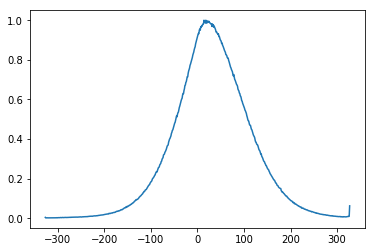

/media/shad/DATA/MuzAnalysis/Disturbed/[2000] The Sickness (10th Anniversary Edition)/01 - Voices.mp3


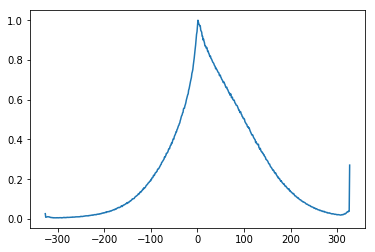

/media/shad/DATA/MuzAnalysis/Disturbed/[2000] The Sickness (10th Anniversary Edition)/02 - The Game.mp3


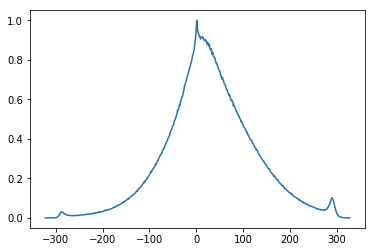

In [45]:
i = 0
for k, v in all_data.items():
    if i < 3:
        i+=1
        print(k)
        plt.plot(v)
        plt.show()
    else:
        break

In [158]:
#all_data2
type(all_data_clean_dict[0][0])
#print(k,v)
#a,b = prodj[0]
#print(a,b)

str

In [163]:
# from itertools import product
print("Pairs to compare: " + str(len(prodj)))

comparing_data = []#pd.DataFrame()
comparing_counter = 0
for song1_name, song2_name in prodj:
    comparing_counter+=1
    if (comparing_counter%100000==0 
        or comparing_counter==10 
        or comparing_counter==50
        or comparing_counter==100
        or comparing_counter==500
        or comparing_counter==1000
        or comparing_counter==10000
        or comparing_counter==50000
       ):
        print(str(datetime.now()) + " Compared " + str(comparing_counter) + " songs.")
    if song1_name == song2_name:
        print("Comparing to itself :(")
    result = pd.concat([
        all_data_clean_dict[song1_name], 
        all_data_clean_dict[song2_name]], 
        axis=1, join='inner').fillna(0) #join_axes=[song1_data.index]
    result['dif'] = abs(result[0] - result[1])
    #print(str(sum(result['dif'])) + " for " + song2_name)
    comparing_data.append((song1_name, song2_name, sum(result['dif'])))

print(str(datetime.now()) + " Compared " + str(comparing_counter) + " songs.")
print("Finished!")

Pairs to compare: 4950
2019-04-24 20:19:12.105078 Compared 10 songs.
2019-04-24 20:19:12.247284 Compared 50 songs.
2019-04-24 20:19:12.348490 Compared 100 songs.
2019-04-24 20:19:13.007956 Compared 500 songs.
2019-04-24 20:19:13.803424 Compared 1000 songs.
2019-04-24 20:19:21.115289 Compared 4950 songs.
Finished!


In [176]:
#keys = list(all_data_df[0])
index = all_data_df.index.union(all_data_df[0])
all_data_df = all_data_df.reindex(index=index, columns=index, fill_value=0)
print(all_data_df)

                                                                                                    0  \
0                                                   Disturbed/Disturbed - Fade to Black (Metallica...   
1                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
2                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
3                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
4                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
5                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
6                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
7                                                   Disturbed/[2000] The Sickness (10th Anniversar...   
8                                                   Dis

/home/shad/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  exec(code_obj, self.user_global_ns, self.user_ns)


In [170]:
import networkx as nx
G = G=nx.from_numpy_matrix(comparing_data)
nx.draw(G)

AttributeError: 'list' object has no attribute 'shape'

## Product join of all elements

In [158]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)


cut_path = len("/media/shad/DATA/MuzAnalysis/")
cd = [(c[0][cut_path:], c[1][cut_path:], c[2]) for c in comparing_data]
sizes = [c[2] for c in cd]
size_buckets = {}
for s in sizes:
    ns = int(s/10)
    if ns in size_buckets:
        size_buckets[ns] += 1
    else:
        size_buckets[ns] = 1

pp.pprint(size_buckets)

{   0: 10338,
    1: 77362,
    2: 128628,
    3: 145312,
    4: 147370,
    5: 138464,
    6: 121552,
    7: 103934,
    8: 87288,
    9: 74542,
    10: 63322,
    11: 52128,
    12: 42650,
    13: 33846,
    14: 26362,
    15: 19392,
    16: 13768,
    17: 9448,
    18: 6168,
    19: 3814,
    20: 2118,
    21: 1152,
    22: 524,
    23: 254,
    24: 98,
    25: 24,
    26: 20,
    28: 2}


In [186]:
#song1_data = all_data['/home/shad/Projects/GanreAnalizer/Samples/DB.mp3']
#song2_data = all_data['/home/shad/Projects/GanreAnalizer/Samples/mp3/02 No Education.mp3']

#result = pd.concat([song1_data, song2_data], axis=1, join='inner').fillna(0)
#result['dif'] = abs(result[0] - result[1])
#print(result)
#result.to_csv(index=True, path_or_buf='/home/shad/Projects/GanreAnalizer/Samples/DB_vs_Ed.csv')
len(top_simil)
top_simil.to_csv(index=True, path_or_buf='/home/shad/Projects/GanreAnalizer/Samples/Comparing.csv')

# Web parser

In [ ]:

r = req.get('https://lyrics.fandom.com/wiki/3_Doors_Down')


In [ ]:
print(r.content)

In [ ]:
# Getting ganres
b1 = bands[0]
url = "https://lyrics.fandom.com/wiki/" + "_".join(b1.split(" "))
r = req.get(url)
print(r.content)

In [ ]:
# Parsing out ganres
pq = PyQuery(r.content)
print(pq)

</div></div><div class="css-table-cell">
<p class="highlight"><b>Genres:</b></p><div>
<ul><li><a href="/wiki/Category:Genre/Alternative_Rock" title="Category:Genre/Alternative Rock">Alternative Rock</a>
</li><li><a href="/wiki/Category:Genre/Pop_Rock" title="Category:Genre/Pop Rock">Pop Rock</a>
</li><li><a href="/wiki/Category:Genre/Post-Grunge" title="Category:Genre/Post-Grunge">Post-Grunge</a>
</li></ul>
</div>